## Classification of Breast Cancer Cell Samples with kNN, Logistic Regression, and Random Forest

In this notebook, we compare the performance of three supervised machine learning algorithms—k-Nearest Neighbors (kNN), Logistic Regression, and Random Forest—for classifying breast cancer cell samples as benign or malignant. The objective is to identify the model that best detects malignant tumors with a high recall rate, as this is critical in a medical diagnostic context. We preprocess and train the models using the provided training data, evaluate their performance on a separate test dataset, and finally apply the best-performing classifier to predict the tumor types in an unseen target dataset

In [3]:
############################################
# Read data
############################################

# Import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# File paths for the datasets
train_file_path = '/Users/derphantomben/Documents/Coding/Portfolio/Breast Cancer Challenges/Challenge No 1/breastcancer_train.csv'
test_file_path = '/Users/derphantomben/Documents/Coding/Portfolio/Breast Cancer Challenges/Challenge No 1/breastcancer_test.csv'
aim_file_path = '/Users/derphantomben/Documents/Coding/Portfolio/Breast Cancer Challenges/Challenge No 1/breastcancer_aim.csv'

# Read datasets and treat 'null' strings as NaN
df_train = pd.read_csv(train_file_path, na_values='null')
df_test = pd.read_csv(test_file_path, na_values='null')
df_aim = pd.read_csv(aim_file_path, na_values='null')

# Adjust data types
df_train['id'] = df_train['id'].astype('category')
df_train['class'] = df_train['class'].astype('category')
df_test['id'] = df_test['id'].astype('category')
df_test['class'] = df_test['class'].astype('category')
df_aim['id'] = df_aim['id'].astype('category')

# Drop missing values from training data
df_train = df_train.dropna()

I will begin by preparing the data for machine learning by **defining the target vectors and feature matrices**, excluding columns like "id" and "class" that are not needed for the model. I'll analyze the **class distribution** in both the training and test datasets to check for any imbalances. Next, I'll visualize the **correlation matrix** to identify any multicollinearity between features. To address this, I'll select only the weakly correlated features, **reducing the complexity of the model**. Finally, I’ll standardize the reduced feature set using **`StandardScaler` to ensure that the features are on the same scale**, which will improve the performance and stability of the model.

Training data – class distribution:
class
0    0.653775
1    0.346225
Name: proportion, dtype: float64

Test data – class distribution:
class
0    0.614286
1    0.385714
Name: proportion, dtype: float64


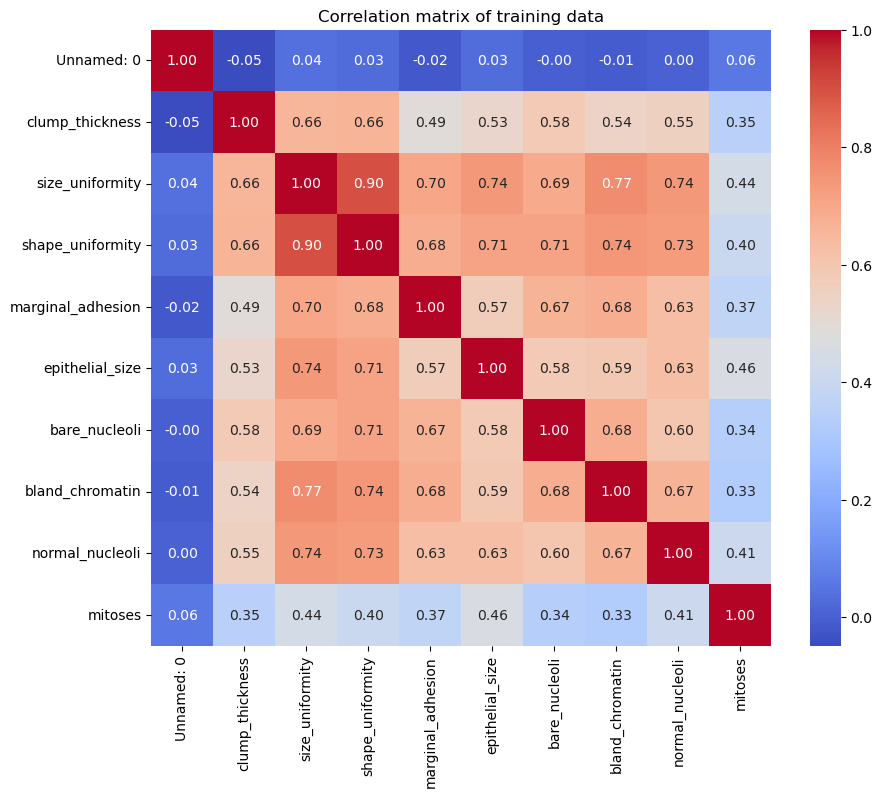

In [5]:
############################################
# Prepare features and target
############################################

# Define target vectors
y_train = df_train["class"]
y_test = df_test["class"]

# Create feature matrices (exclude 'id' and 'class')
X_train = df_train.drop(columns=["id", "class"])
X_test = df_test.drop(columns=["id", "class"])
X_aim = df_aim.drop(columns=["id"])

############################################
# Analyze class distributions
############################################

print("Training data – class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest data – class distribution:")
print(y_test.value_counts(normalize=True))

############################################
# Correlation matrix
############################################

plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix of training data")
plt.show()

############################################
# Reduce features to avoid multicollinearity
############################################

# Retain only weakly correlated features
features_selected = ["bland_chromatin", "mitoses"]

X_train_reduced = X_train[features_selected]
X_test_reduced = X_test[features_selected]
X_aim_reduced = X_aim[features_selected]

############################################
# Standardize reduced features
############################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)
X_aim_scaled = scaler.transform(X_aim_reduced)

**Evaluation**
The class distribution in the training and test datasets shows that both datasets are imbalanced, with class 0 being more prevalent than class 1. In the training data, class 0 accounts for approximately 65.4% of the samples, while class 1 makes up around 34.6%. In the test data, class 0 comprises about 61.4%, and class 1 accounts for 38.6%. This imbalance should be considered when choosing evaluation metrics or model techniques, as it may influence the model's performance, particularly for predicting the minority class.

To evaluate the performance of the **k-Nearest-Neighbors (k-NN)** classification model, we can perform a GridSearch to find the optimal value for the n_neighbors parameter. The n_neighbors parameter specifies how many neighbors should be considered during classification. A reasonable search range for this parameter would be from 1 to 20, as this typically provides a good range of values for k-NN models

In [6]:
############################################
# k-Nearest-Neighbors (k-NN) classification model
############################################

# Import packages
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Define the model
knn = KNeighborsClassifier()

# Define the search space for the n_neighbors parameter
param_grid = {
    'n_neighbors': range(1, 21)  # k from 1 to 20
}

# Perform GridSearch with Cross-Validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Best parameters and performance
print("Best parameters for k-NN:", grid_search.best_params_)
print("Best performance on training data:", grid_search.best_score_)

# Predictions and performance evaluation on the training data
y_train_pred = grid_search.predict(X_train_scaled)
print("\nClassification report for the best k-NN model on the training data:")
print(classification_report(y_train, y_train_pred))

Best parameters for k-NN: {'n_neighbors': 5}
Best performance on training data: 0.9301053346924906

Classification report for the best k-NN model on the training data:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       355
           1       0.90      0.90      0.90       188

    accuracy                           0.93       543
   macro avg       0.93      0.93      0.93       543
weighted avg       0.93      0.93      0.93       543



**Evaluation**
k-Nearest-Neighbors (k-NN) model with n_neighbors = 5 achieved an accuracy of 93% on the training data. The classification report highlights strong performance, with a precision of 0.95 for class 0 (benign) and 0.90 for class 1 (malignant). Recall values are also high, with 0.95 for class 0 and 0.90 for class 1, showing that the model is effective in identifying both classes. The F1-scores for both classes are balanced (0.95 for class 0 and 0.90 for class 1), demonstrating a good trade-off between precision and recall. Overall, the model performs well in predicting Benign (good tumor) vs. Malignant (cancerous tumor) cancer cells.

To identify the **best logistic regression model**, I will perform a step-by-step GridSearch process for the C and penalty parameters. First, I will perform a wide-ranging search with large step sizes to get a general sense of the optimal values for these parameters. Based on the results of this first search, I will then narrow down the search space and perform a second, more focused grid search. I will repeat this process until I find the best logistic regression model.

In [8]:
############################################
# Best logistic regression model
############################################

# Import packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the model
log_reg = LogisticRegression(max_iter=10000)

# First wide GridSearch for C and penalty parameters
param_grid_1 = {
    'C': [0.1, 1, 10, 100, 1000],  # Wide range for C
    'penalty': ['l1', 'l2']         # L1 and L2 regularization
}

# Perform GridSearch with Cross-Validation
grid_search_1 = GridSearchCV(log_reg, param_grid_1, cv=5, scoring='accuracy')
grid_search_1.fit(X_train_scaled, y_train)

# Best parameters and performance from the first search
print("Best parameters from first GridSearch:", grid_search_1.best_params_)
print("Best performance from first GridSearch:", grid_search_1.best_score_)

# Second, narrower GridSearch based on the first search results
param_grid_2 = {
    'C': [grid_search_1.best_params_['C'] / 10, grid_search_1.best_params_['C'], grid_search_1.best_params_['C'] * 10],  # Narrow range around the best C
    'penalty': [grid_search_1.best_params_['penalty']]  # best penalty from the first search
}

# Perform second GridSearch with Cross-Validation
grid_search_2 = GridSearchCV(log_reg, param_grid_2, cv=5, scoring='accuracy')
grid_search_2.fit(X_train_scaled, y_train)

# Best parameters and performance from the second search
print("Best parameters from second GridSearch:", grid_search_2.best_params_)
print("Best performance from second GridSearch:", grid_search_2.best_score_)

# Classification report for the best model on the training data
y_train_pred = grid_search_2.predict(X_train_scaled)
print("\nClassification report for the best Logistic Regression model on the training data:")
print(classification_report(y_train, y_train_pred))

Best parameters from first GridSearch: {'C': 100, 'penalty': 'l2'}
Best performance from first GridSearch: 0.9117227319062182
Best parameters from second GridSearch: {'C': 100, 'penalty': 'l2'}
Best performance from second GridSearch: 0.9117227319062182

Classification report for the best Logistic Regression model on the training data:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       355
           1       0.93      0.81      0.87       188

    accuracy                           0.91       543
   macro avg       0.92      0.89      0.90       543
weighted avg       0.91      0.91      0.91       543



/opt/anaconda3/envs/jupyter-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/jupyter-env/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/jupyter-env/lib/python3.11/site-packa

**Evaluation**
The logistic regression model with `C = 100` and `penalty = 'l2'` achieved an accuracy of approximately 91% on the training data. The classification report shows strong performance, with a precision of 0.91 for class 0 (employees staying) and 0.93 for class 1 (employees leaving). Recall is higher for class 0 (0.97) than for class 1 (0.81), indicating that the model is more effective at identifying employees staying. The F1-scores are 0.94 for class 0 and 0.87 for class 1, showing a good balance between precision and recall, although class 1 could be further improved. Some fits failed during cross-validation due to compatibility issues with the solver and L1 penalty, but the L2 penalty performed well, making the logistic regression model a strong candidate for predicting employee turnover.

For the **Random Forest classifier**, no standardize the features are needed, as the algorithm is not sensitive to feature scaling. To find the best Random Forest model, GridSearchCV can be used to search for the optimal hyperparameters like n_estimators (number of trees) and max_depth (depth of the trees).

In [9]:
############################################
# Random Forest
############################################

# Import packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the model
rf = RandomForestClassifier(random_state=42)

# GridSearch to find best hyperparameters
param_grid_rf = {
    'n_estimators': [100, 200, 300],   # Number of trees
    'max_depth': [None, 10, 20, 30],    # Max depth of the trees
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]       # Minimum samples required to be at a leaf node
}

# Perform GridSearch with Cross-Validation
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# Best parameters and performance from GridSearch
print("Best parameters from GridSearch:", grid_search_rf.best_params_)
print("Best performance from GridSearch:", grid_search_rf.best_score_)

Best parameters from GridSearch: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best performance from GridSearch: 0.9742609582059124


**Evaluation** The model achieved a best performance score of 0.974 on the training data. This indicates that the Random Forest model, with these optimized hyperparameters, performs exceptionally well in classifying the training data.

Based on that I will proceed with **evaluating this model on the test set** to assess its generalization performance.

In [10]:
# Get the classification report for the best model on the training data
y_train_pred_rf = grid_search_rf.predict(X_train)
print("\nClassification report for the best Random Forest model on the training data:")
print(classification_report(y_train, y_train_pred_rf))

# Evaluate the model on the test data
y_test_pred_rf = grid_search_rf.predict(X_test)
print("\nClassification report for the best Random Forest model on the test data:")
print(classification_report(y_test, y_test_pred_rf))


Classification report for the best Random Forest model on the training data:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       355
           1       0.97      0.99      0.98       188

    accuracy                           0.99       543
   macro avg       0.98      0.99      0.99       543
weighted avg       0.99      0.99      0.99       543


Classification report for the best Random Forest model on the test data:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        43
           1       0.96      0.96      0.96        27

    accuracy                           0.97        70
   macro avg       0.97      0.97      0.97        70
weighted avg       0.97      0.97      0.97        70



**Evaluation** the Random Forest model performs well, with just a small drop in performance on the test data compared to the training data Side note: This is is typical for real-world applications where models might not perfectly generalize.

In [13]:
# Drop the 'class' column from X_aim (needed to ensure consistency between columns between data sets and avoid error)
X_aim = X_aim.drop(columns=['class'])

# Now you can make predictions using the trained model
y_aim_pred_rf = grid_search_rf.predict(X_aim)

# Count the number of malignant tumors (class 1)
malignant_tumors = sum(y_aim_pred_rf == 1)
print(f"Number of malignant tumors in the aim dataset: {malignant_tumors}")

Number of malignant tumors in the aim dataset: 26


**What are the limitations of the chosen model?**

The limitations of the best classification model, Random Forest, include potential overfitting if the model is too complex, limited interpretability as it's a black-box model, and higher memory and computation costs, especially with large datasets. It also requires sufficient data to perform well and may be sensitive to class imbalances, though it generally handles them better than some other models.